# gen fonts

In [ ]:
from fontTools.ttLib import TTFont
from fontTools.pens.basePen import BasePen
from reportlab.graphics.shapes import Path
from reportlab.lib import colors
from reportlab.graphics import renderPM
from reportlab.graphics.shapes import Group, Drawing, scale

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [ ]:
class ReportLabPen(BasePen):
 
  """A pen for drawing onto a reportlab.graphics.shapes.Path object."""

  def __init__(self, glyphSet, path=None):
    BasePen.__init__(self, glyphSet)
    if path is None:
      path = Path()
    self.path = path

  def _moveTo(self, p):
    (x,y) = p
    self.path.moveTo(x,y)

  def _lineTo(self, p):
    (x,y) = p
    self.path.lineTo(x,y)

  def _curveToOne(self, p1, p2, p3):
    (x1,y1) = p1
    (x2,y2) = p2
    (x3,y3) = p3
    self.path.curveTo(x1, y1, x2, y2, x3, y3)

  def _closePath(self):
    self.path.closePath()


In [ ]:
def ttfToImage(fontName,imagePath,fmt="png"):
    font = TTFont(fontName)
    gs = font.getGlyphSet()
    glyphNames = font.getGlyphNames()
    for i in glyphNames:

        if i.startswith('uni') == False:
            continue
        elif int(i[3:7], 16) < 19968 or int(i[3:7], 16) > 40943:
            continue
        
        g = gs[i]
        pen = ReportLabPen(gs, Path(fillColor=colors.black))
        g.draw(pen)
        w=128
        h=128
        g = Group(pen.path)
        g.translate(0, 26)
        g.scale(0.125, 0.125)
        
        d = Drawing(w, h)
        d.add(g)
        imageFile = imagePath+"/"+i+".png"
        renderPM.drawToFile(d, imageFile, fmt)
        print(i + ' ', end='')


In [ ]:
# ttfToImage(fontName="STZHONGS.TTF", imagePath="fonts")

In [ ]:
font_png_list = os.listdir('fonts')

In [ ]:
len(a)

In [ ]:
font_nps = []
c = 0
for i in font_png_list:
  font_np = mpimg.imread('fonts/' + i)
  font_nps.append(font_np[:,:,0])
  c += 1
  if c % 100 == 0:
    print(c)

In [ ]:
len(font_nps)

In [ ]:
plt.imshow(font_nps[2].astype(np.int8))

In [ ]:
font_nps = np.array(font_nps)

In [ ]:
np.save('STZHONGS', font_nps.astype(np.int8))

# GAN

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data  import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class FontDataset(Dataset):
  def __init__(self):
    self.fonts_arr = None
    self.fonts_arr = np.load('STZHONGS.npy')

  def __getitem__(self, idx):
    font_np = self.fonts_arr[idx]
    return torch.from_numpy(font_np).type(torch.float32)

  def __len__(self):
    return len(self.fonts_arr)

In [6]:
font_dataset = FontDataset()

In [11]:
bs = 32
font_loader = torch.utils.data.DataLoader(dataset=font_dataset, batch_size=bs, shuffle=True)

In [12]:
def img_show(img):
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

In [13]:
z_dim = 100

def gen_fake_inputs(batch):
  return Variable(torch.randn(batch, z_dim).to(device))

def gen_labels(batch, value):
  return Variable((torch.zeros(batch, 1) + value).to(device))

In [14]:
def write_to_log(msg):
  with open('font_log.txt', 'a') as f:
    f.write(msg + '\n')

In [41]:
class Generator(nn.Module):
  def __init__(self, g_input_dim):
    super(Generator, self).__init__()
    self.fc = nn.Linear(g_input_dim, 8*8*128)
    
    self.up1 = self._gen_seq(128, 128)
    self.up2 = self._gen_seq(128, 128)
    self.up3 = self._gen_seq(128, 64)
    self.up4 = self._gen_seq(64, 64)
    self.fin_conv = nn.Conv2d(64, 1, 3, padding=1)
  
  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.Upsample(scale_factor=2),
      nn.LeakyReLU(0.2)
    )

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc(x))
    x = x.reshape(-1, 128, 8, 8)
    x = self.up1(x)
    x = self.up2(x)
    x = self.up3(x)
    x = self.up4(x)
    return torch.tanh(self.fin_conv(x))

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.down1 = self._gen_seq(1, 32)
    self.down2 = self._gen_seq(32, 32)
    self.down3 = self._gen_seq(32, 64)
    self.down4 = self._gen_seq(64, 64)
    self.fc1 = nn.Linear(8*8*64, 1)

  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.MaxPool2d(2),
      nn.LeakyReLU()
    )

  def forward(self, x):
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.down4(x)

    x = x.view(-1, 64*8*8)
    x = self.fc1(x)
    x = torch.sigmoid(x)
    return x

In [42]:
G = Generator(g_input_dim = z_dim).to(device)
D = Discriminator().to(device)

In [43]:
# loss
criterion = nn.BCELoss()

# optimizer
g_lr = 0.0002
d_lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = g_lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = d_lr)

In [44]:
def D_train(x):
  #=======================Train the discriminator=======================#
  D.zero_grad()

  # train discriminator on real
  _bs = x.shape[0]
  x_real, y_real = x, gen_labels(_bs, 1)

  D_output = D(x_real)
  D_real_loss = criterion(D_output, y_real)

  # train discriminator on fake
  z = gen_fake_inputs(_bs)
  x_fake, y_fake = G(z), gen_labels(_bs, 0)

  D_output = D(x_fake)
  D_fake_loss = criterion(D_output, y_fake)

  # gradient backprop & optimize ONLY D's parameters
  D_loss = D_real_loss + D_fake_loss
  D_loss.backward()
  D_optimizer.step()
      
  return  D_loss.data.item()

def G_train():
  #=======================Train the generator=======================#
  G.zero_grad()

  z = gen_fake_inputs(bs)
  y = gen_labels(bs, 1)

  G_output = G(z)
  D_output = D(G_output)
  G_loss = criterion(D_output, y)

  # gradient backprop & optimize ONLY G's parameters
  G_loss.backward()
  G_optimizer.step()
      
  return G_loss.data.item()

In [45]:
fake_len = 12
fake_inputs = gen_fake_inputs(fake_len)
fake_inputs = gen_fake_inputs(fake_len)

def gen_fake_img():
  plt.figure(figsize=(5, 1.6))
  b = G(fake_inputs)
  for i in range(0, fake_len):
    b_n = b[i].cpu().detach()[0]
    plt.subplot(2, int(fake_len / 2), i+1)
    img_show(b_n)
  plt.show()

In [46]:
def test_fake_efficiency(is_round = False):
  e = 10
  s = 0
  for i in range(e):
    a = gen_fake_inputs(bs)
    b = G(a)
    D_output = D(b)
    if is_round:
      D_output = torch.round(D_output)
    D_true = torch.sum(D_output).item() / bs
    s += D_true
  return s / e

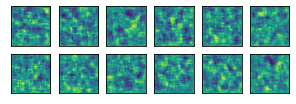

In [47]:
gen_fake_img()

In [48]:
test_fake_efficiency()

0.40724853575229647

In [49]:
n_epoch = 200
d_error_rate = 1


for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  for batch_idx, x in enumerate(font_loader):
    x = x.unsqueeze(1)
    x = Variable(x.to(device))

    if batch_idx % 12 == 0:
      print('|', end='')
    
    D_losses.append(D_train(x))
    G_losses.append(G_train())

  ld = 0
  lg = 0
  if len(D_losses) > 0:
    ld = torch.mean(torch.FloatTensor(D_losses))
  if len(G_losses) > 0:
    lg = torch.mean(torch.FloatTensor(G_losses))

  print()
  d_error_rate = test_fake_efficiency()
  d_error_rate_round = test_fake_efficiency(True)
  msg = '[%d/%d]: loss_d: %.3f, loss_g: %.3f, d_error: %.6f, d_error_round: %.3f' % (
    (epoch), n_epoch, ld, lg, d_error_rate, d_error_rate_round)
  write_to_log(msg)
  print(msg)

  torch.save(G.state_dict(), 'font_generator_1.pth')
  torch.save(D.state_dict(), 'font_discriminator_1.pth')
  
  gen_fake_img()

||||